In [5]:
# Find image size distribution

import os
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
widths = []
heights = []
root_dir = 'listing_images'

for grade in ['psa 7', 'psa 8', 'psa 9', 'psa 10']:
    grade_dir = os.path.join(root_dir, grade)
    for folder in os.listdir(grade_dir):
        image_path = os.path.join(grade_dir, folder, '$_3.JPG')
        if os.path.exists(image_path):
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)

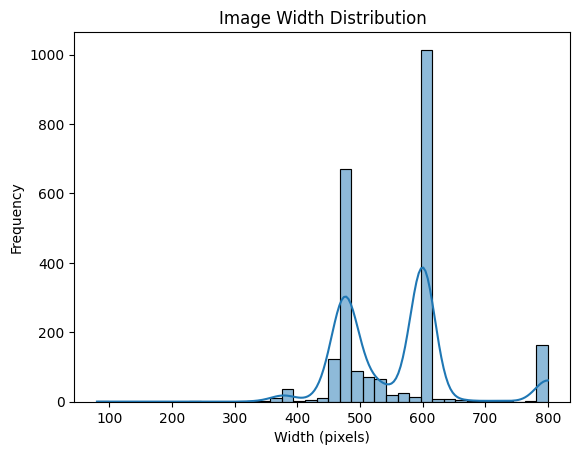

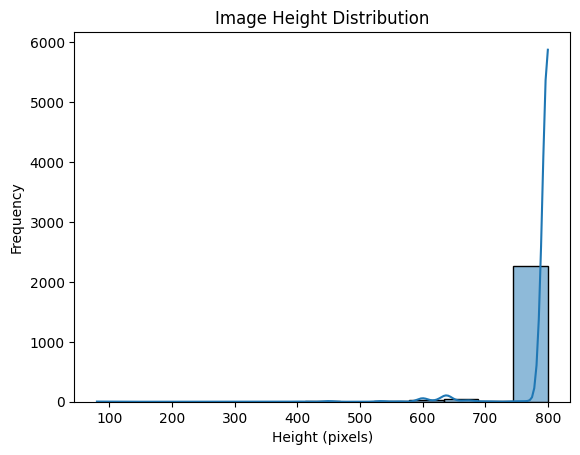

In [7]:
import seaborn as sns

sns.histplot(widths, kde=True)
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

sns.histplot(heights, kde=True)
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

In [42]:
# Create DataFrame

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = []

for grade in ['psa 7', 'psa 8', 'psa 9', 'psa 10']:
    grade_dir = os.path.join(root_dir, grade)
    for folder in os.listdir(grade_dir):
        image_path = os.path.join(grade_dir, folder, '$_3.JPG')
        if os.path.exists(image_path):
            data.append({'image_path': image_path, 'label': grade})

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,image_path,label
0,listing_images\psa 9\335527870473\$_3.JPG,psa 9
1,listing_images\psa 8\395620036836\$_3.JPG,psa 8
2,listing_images\psa 9\315958947993\$_3.JPG,psa 9
3,listing_images\psa 10\284840240969\$_3.JPG,psa 10
4,listing_images\psa 7\235810137370\$_3.JPG,psa 7


In [43]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [44]:
# Preprocess images into standard sizes

TARGET_SIZE = (384, 512)

def resize_and_pad_image(image_array, target_size):
    """
    Resizes and pads the image to the target size while maintaining aspect ratio.
    """
    img = Image.fromarray(image_array.astype('uint8'), 'RGB')
    img.thumbnail(target_size, Image.LANCZOS)
    new_img = Image.new('RGB', target_size, (0, 0, 0))  # Black background
    paste_x = (target_size[0] - img.size[0]) // 2
    paste_y = (target_size[1] - img.size[1]) // 2
    new_img.paste(img, (paste_x, paste_y))
    return np.array(new_img)

def custom_preprocess_input(image_array):
    """
    Custom preprocessing function for ImageDataGenerator.
    """
    image_array = resize_and_pad_image(image_array, TARGET_SIZE)
    image_array = resnet_preprocess_input(image_array)
    return image_array

In [45]:
# Data augmentation

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.models import Model

BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess_input,
    rotation_range=10,          # Small rotations
    width_shift_range=0.05,     # Small horizontal shifts
    height_shift_range=0.05,    # Small vertical shifts
    horizontal_flip=True,       # Horizontal flip (if applicable)
    fill_mode='constant',       # Fill with constant (black) during shifts
    cval=0                      # Black color for padding
)

val_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess_input
)

# Create Generators from DataFrames

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_SIZE[1], TARGET_SIZE[0]),  # (height, width) = (512, 384)
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_SIZE[1], TARGET_SIZE[0]),  # (height, width) = (512, 384)
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1885 validated image filenames belonging to 4 classes.
Found 472 validated image filenames belonging to 4 classes.


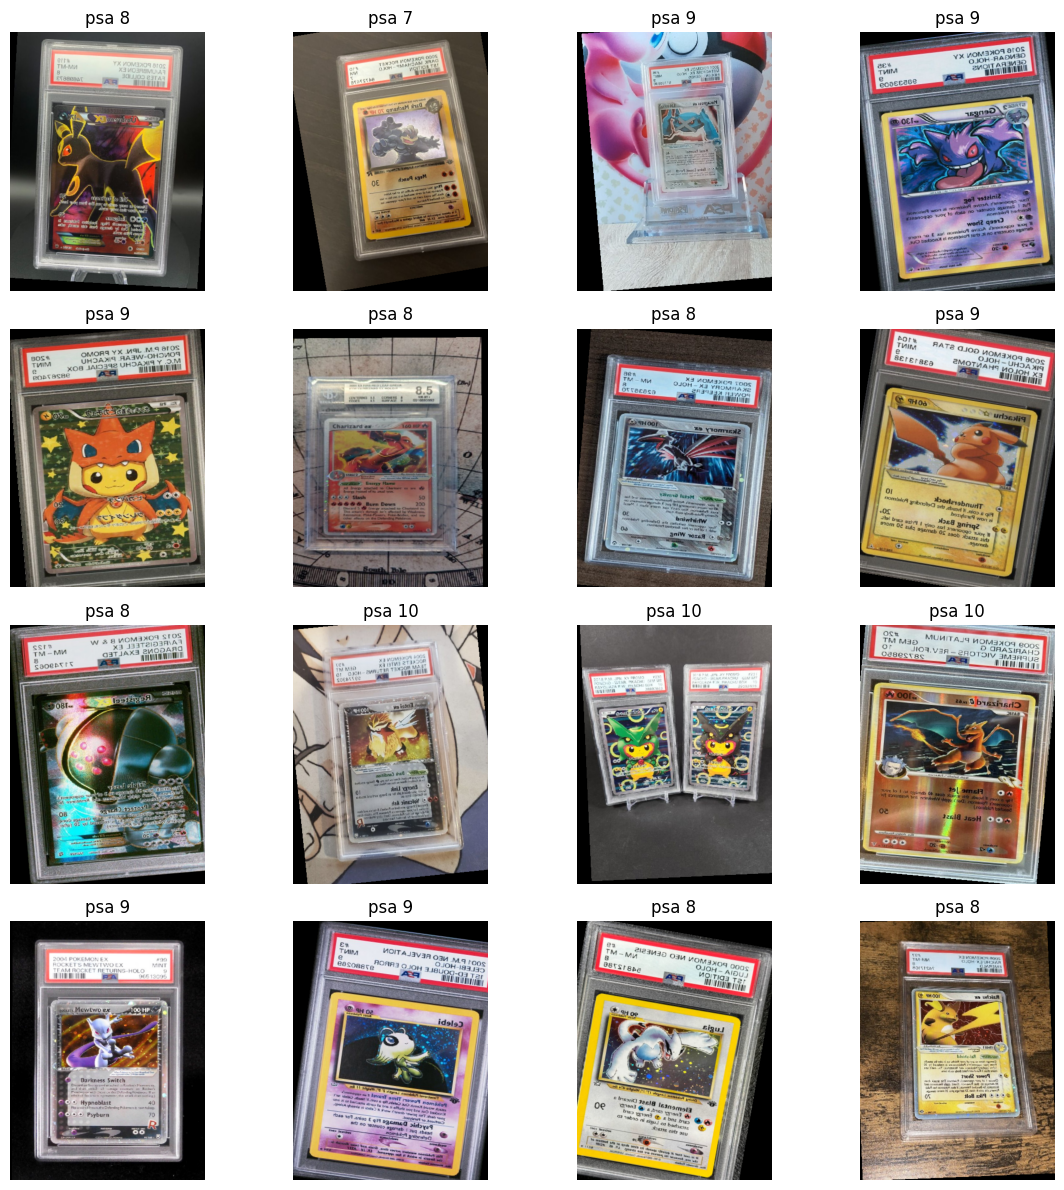

In [46]:
images, labels = next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(0, min(len(images), 16)):
    plt.subplot(4, 4, i+1)
    img = images[i].copy()
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img.astype('uint8')
    img = img[:, :, ::-1]
    plt.imshow(img)
    label_indices = np.argmax(labels[i])
    class_label = list(train_generator.class_indices.keys())[label_indices]
    plt.title(class_label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [52]:
# Build and train model using ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import math

input_shape = (TARGET_SIZE[1], TARGET_SIZE[0], 3)  # (512, 384, 3)
CLASSES = ['psa 7', 'psa 8', 'psa 9', 'psa 10']

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=8, restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / val_generator.batch_size),
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.2650 - loss: 1.6559 - val_accuracy: 0.2797 - val_loss: 1.4126
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


c:\Users\Brendan\anaconda3\envs\myenv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\Brendan\anaconda3\envs\myenv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\Brendan\anaconda3\envs\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.2848 - loss: 1.4653 - val_accuracy: 0.2966 - val_loss: 1.4053
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.3451 - loss: 1.3994 - val_accuracy: 0.2924 - val_loss: 1.4916
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.3448 - loss: 1.3643 - val_accuracy: 0.2797 - val_loss: 1.3845
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.3342 - loss: 1.3393 - val_accuracy: 0.2860 - val_loss: 1.4043
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.3876 - loss: 1.3162 - val_accuracy: 0.3093 - val_loss: 1.387

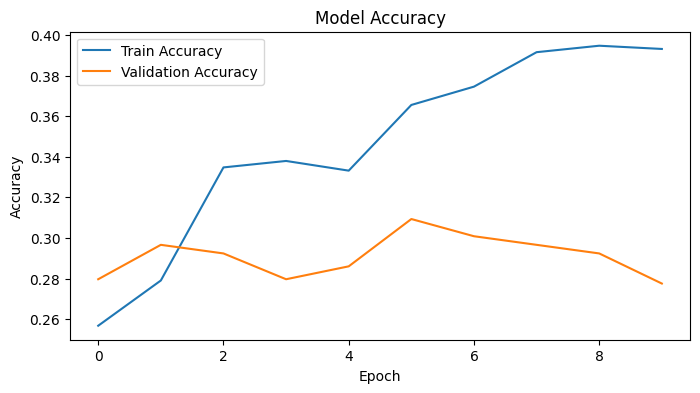

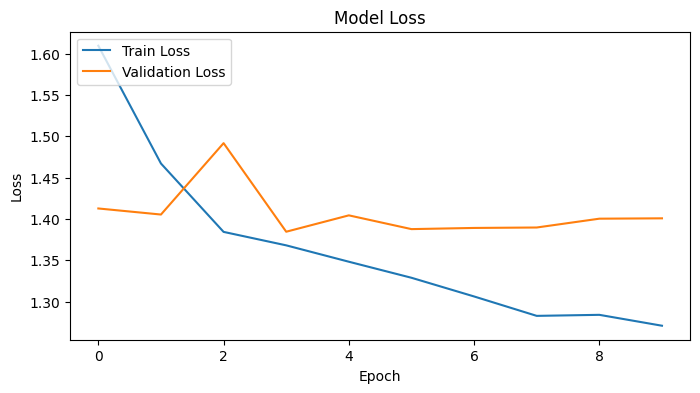

14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3210 - loss: 1.3862
Validation Loss: 1.3937
Validation Accuracy: 0.3036


In [57]:
# Evaluate the Model
odd_indices = [i for i in range(20) if (i + 1) % 2 != 0]
odd_epochs = [i + 1 for i in odd_indices]
train_accuracy_odd = [history.history['accuracy'][i] for i in odd_indices]
train_loss_odd = [history.history['loss'][i] for i in odd_indices]

plt.figure(figsize=(8, 4))
plt.plot(train_accuracy_odd, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_odd, label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

model.save('psa_classification_model.keras')